In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('sustainability_dataset.csv')

In [3]:
data

Product  Raw Material (kg CO2)  Weaving (kg CO2)  \
0           Cabin Crew Jacket                    2.0               4.3   
1    Athletic Performance Tee                    1.1               2.2   
2        Slip-Resistant Clogs                    1.4               0.8   
3         Hiking Shell Jacket                    3.2               5.2   
4        Slip-Resistant Clogs                    2.4               1.5   
..                        ...                    ...               ...   
995           Steel Toe Boots                    3.3               2.0   
996   Waterproof Hiking Boots                    3.5               2.2   
997     Construction Coverall                    3.3               4.7   
998                 Chef Coat                    2.0               4.0   
999         Mechanic Jumpsuit                    3.1               4.4   

     Dyeing (kWh)  Finishing (Litres H2O)  Energy Used (kWh)  \
0             5.9                     974               18.9   
1             3.7                     495               11.0   
2             2.7                     398               13.2   
3             7.7                    1145               26.7   
4             3.4                     473               17.0   
..            ...                     ...                ...   
995           5.2                     770               26.9   
996           4.7                     641               22.5   
997           7.1                    1034               22.8   
998           5.7                     786               18.5   
999           6.1                     977               21.5   

     Water Used (Litres)  CO2 Used (kg) Sustainability Grade  
0                   1050           10.0                    C  
1                    583            6.1                    B  
2                    331            8.7                    A  
3                   1333           15.2                    D  
4                    631           11.0                    B  
..                   ...            ...                  ...  
995                  868           15.6                    C  
996                  805           14.0                    C  
997                 1397           14.5                    C  
998                 1074           10.4                    C  
999                 1343           11.9                    C  

[1000 rows x 9 columns]

In [4]:
# Check info and missing values
print("\nDataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 1000 non-null   object 
 1   Raw Material (kg CO2)   1000 non-null   float64
 2   Weaving (kg CO2)        1000 non-null   float64
 3   Dyeing (kWh)            1000 non-null   float64
 4   Finishing (Litres H2O)  1000 non-null   int64  
 5   Energy Used (kWh)       1000 non-null   float64
 6   Water Used (Litres)     1000 non-null   int64  
 7   CO2 Used (kg)           1000 non-null   float64
 8   Sustainability Grade    1000 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 70.4+ KB
None

Missing Values:
Product                   0
Raw Material (kg CO2)     0
Weaving (kg CO2)          0
Dyeing (kWh)              0
Finishing (Litres H2O)    0
Energy Used (kWh)         0
Water Used (Litres)       0
CO2 Used 

In [5]:
# Select features and target
X = data.drop(['Product', 'Sustainability Grade'], axis=1)
y = data['Sustainability Grade']

In [6]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Original labels:", label_encoder.classes_)
print("Encoded labels:", np.unique(y_encoded))

Original labels: ['A' 'B' 'C' 'D']
Encoded labels: [0 1 2 3]


In [7]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 800 samples
Test set size: 200 samples


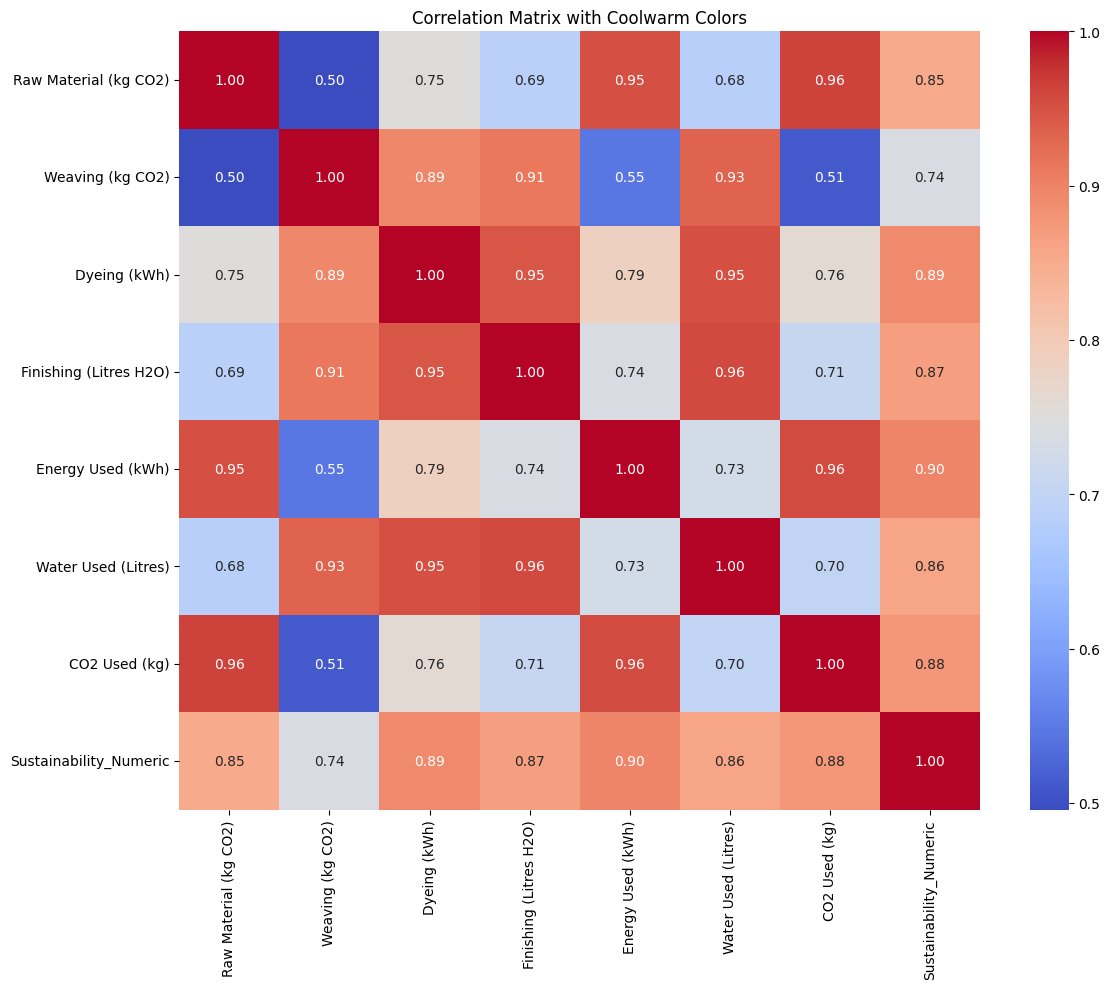

In [ ]:
#  Correlation Matrix Visualization
plt.figure(figsize=(12, 10))
# Create a numeric version of the target for correlation
data['Sustainability_Numeric'] = label_encoder.transform(data['Sustainability Grade'])
correlation_data = data.drop(['Product', 'Sustainability Grade'], axis=1)
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Coolwarm Colors')
plt.tight_layout()
plt.show()

In [ ]:
# Define Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate model performance with various metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # For ROC curve and AUC score
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        # For SVM, we need to use decision_function
        if hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
            # We need to convert decision function output to pseudo-probabilities
            y_proba = np.zeros((len(y_score), len(np.unique(y_train))))
            for i in range(len(y_score)):
                y_proba[i, y_score[i] > 0] = 1
        else:
            y_proba = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, 
                                         target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\nCross-Validation (5-fold):")
    print(f"Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curve for multiclass
    if y_proba is not None:
        plt.figure(figsize=(10, 8))
        n_classes = len(np.unique(y_test))
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            # For each class, calculate the ROC curve using one-vs-rest approach
            fpr[i], tpr[i], _ = roc_curve(
                (y_test == i).astype(int), 
                y_proba[:, i] if y_proba.shape[1] > i else np.zeros(len(y_test))
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.plot(
                fpr[i], tpr[i],
                label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})'
            )
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    # Return model and accuracy for comparison
    return model, accuracy



===== Random Forest Classifier =====
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

--- Random Forest Evaluation ---
Accuracy: 0.9850

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           B       1.00      0.97      0.99        80
           C       0.97      0.98      0.98        60
           D       0.98      1.00      0.99        40

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.98      0.99       200


Confusion Matrix:
[[20  0  0  0]
 [ 0 78  2  0]
 [ 0  0 59  1]
 [ 0  0  0 40]]

Cross-Validation (5-fold):
Scores: [0.99375 0.98125 0.9875  1.      0.975  ]
Mean CV Score: 0.9875
Standard Deviation: 0.0088


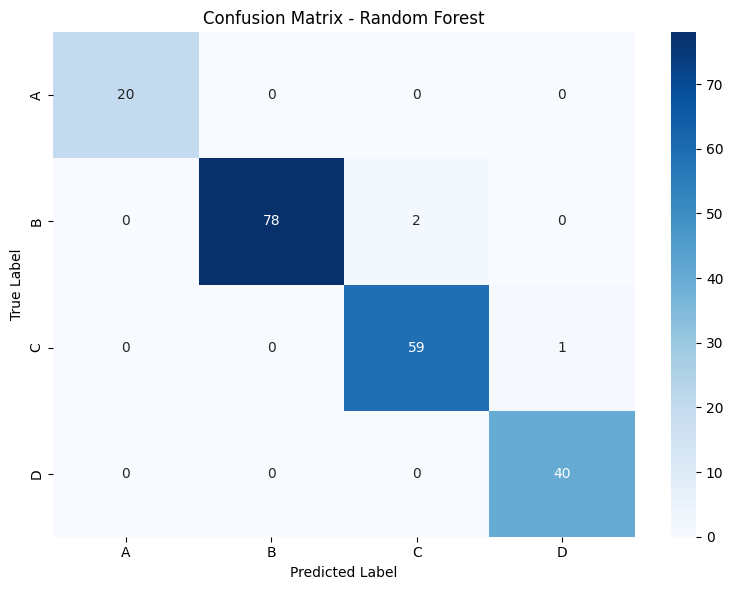

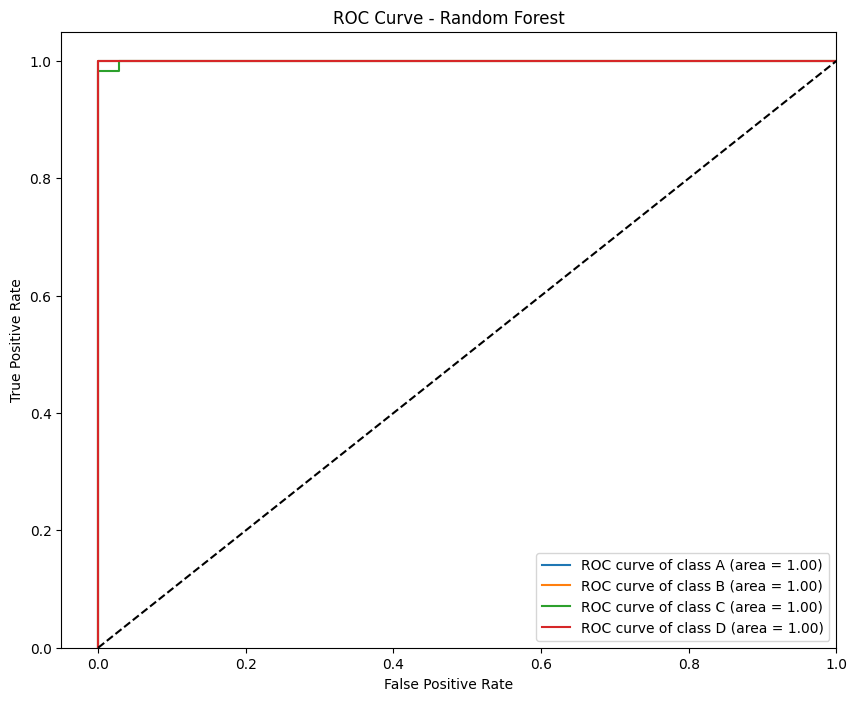

In [ ]:
#  Random Forest Model
print("\n===== Random Forest Classifier =====")

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for grid search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest Parameters for Random Forest:")
print(rf_grid_search.best_params_)

# Evaluate the best model
best_rf_model = rf_grid_search.best_estimator_
rf_model, rf_accuracy = evaluate_model(
    best_rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)


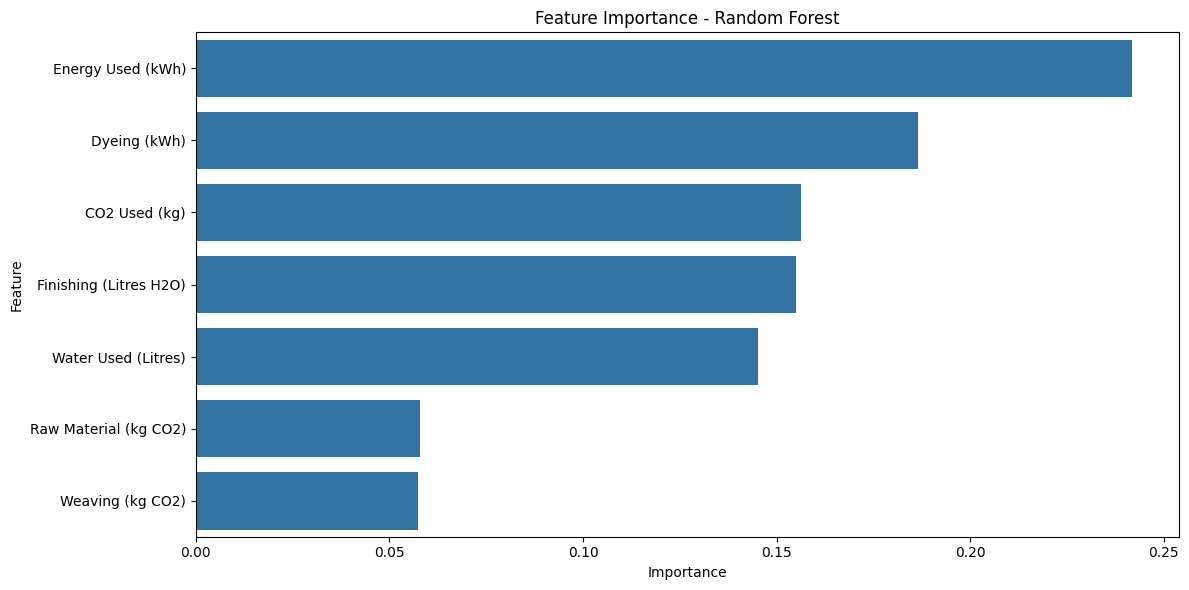

In [12]:
# Feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': best_rf_model.feature_importances_}
)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()


===== Support Vector Machine Classifier =====
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters for SVM:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

--- Support Vector Machine Evaluation ---
Accuracy: 0.9900

Classification Report:
              precision    recall  f1-score   support

           A       0.95      1.00      0.98        20
           B       1.00      0.97      0.99        80
           C       0.98      1.00      0.99        60
           D       1.00      1.00      1.00        40

    accuracy                           0.99       200
   macro avg       0.98      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200


Confusion Matrix:
[[20  0  0  0]
 [ 1 78  1  0]
 [ 0  0 60  0]
 [ 0  0  0 40]]

Cross-Validation (5-fold):
Scores: [0.975   1.      0.99375 0.99375 0.98125]
Mean CV Score: 0.9887
Standard Deviation: 0.0092


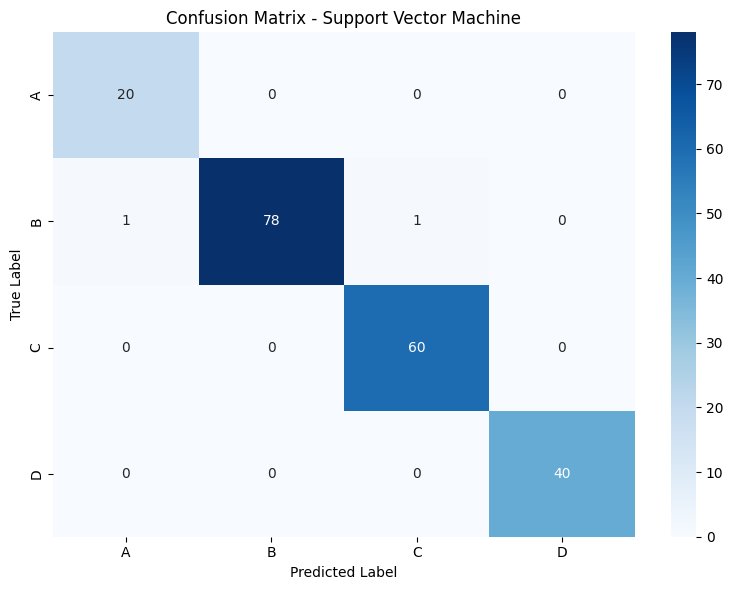

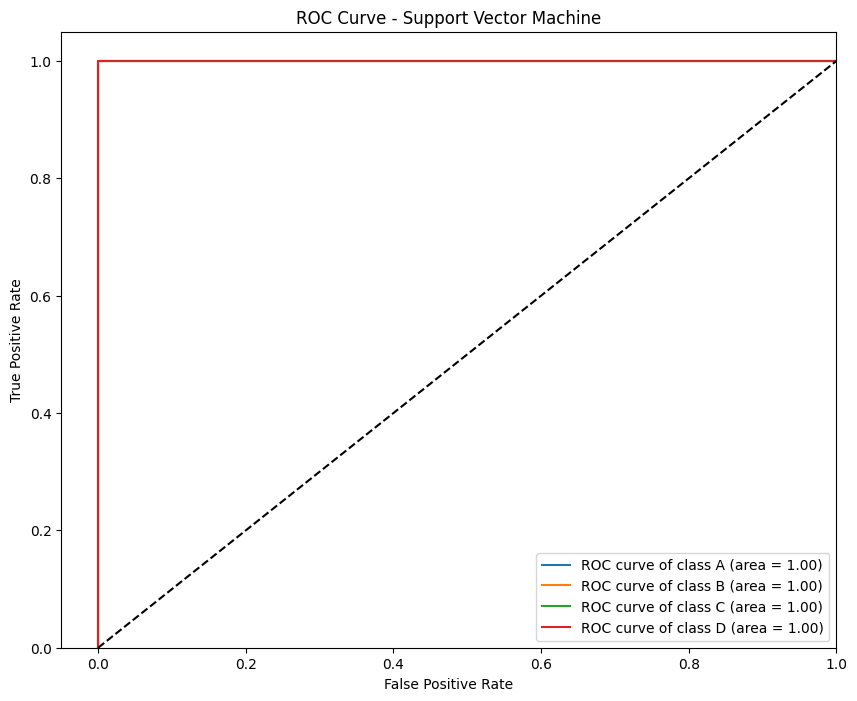

In [ ]:
# Support Vector Machine Model
print("\n===== Support Vector Machine Classifier =====")

# Define the model
svm_model = SVC(probability=True, random_state=42)

# Define parameter grid for grid search
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Perform Grid Search
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

svm_grid_search.fit(X_train, y_train)

# Print best parameters
print("\nBest Parameters for SVM:")
print(svm_grid_search.best_params_)

# Evaluate the best model
best_svm_model = svm_grid_search.best_estimator_
svm_model, svm_accuracy = evaluate_model(
    best_svm_model, X_train, X_test, y_train, y_test, "Support Vector Machine"
)

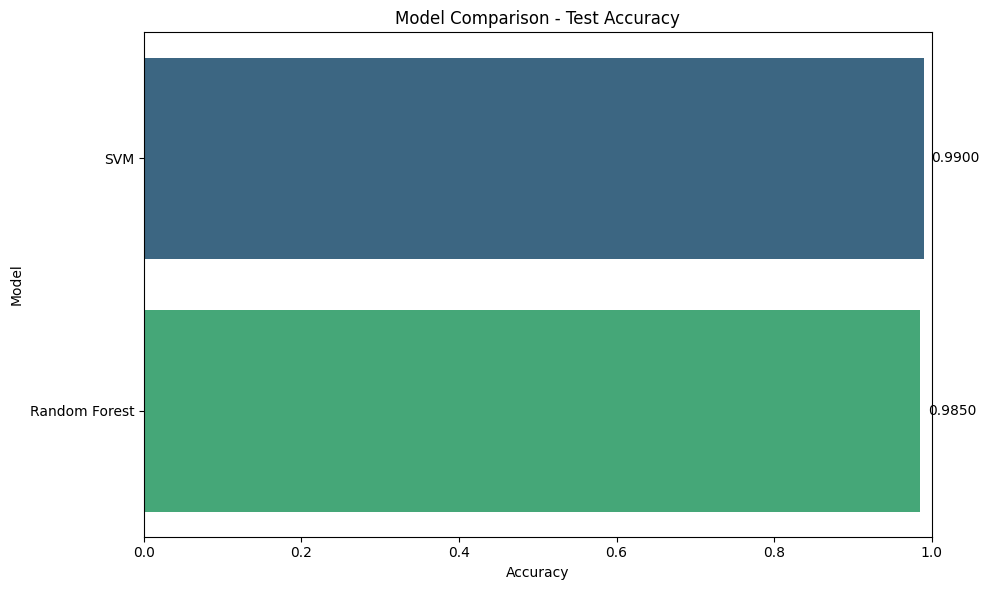


Model Comparison:
           Model  Accuracy
1            SVM     0.990
0  Random Forest     0.985

The best model is SVM with an accuracy of 0.9900


In [ ]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [rf_accuracy, svm_accuracy]
})

# Sort by accuracy
models_comparison = models_comparison.sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=models_comparison, palette='viridis')
plt.title('Model Comparison - Test Accuracy')
plt.xlim(0, 1)
for i, v in enumerate(models_comparison['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

print("\nModel Comparison:")
print(models_comparison)

# Identify the best model
best_model_name = models_comparison.iloc[0]['Model']
best_accuracy = models_comparison.iloc[0]['Accuracy']
print(f"\nThe best model is {best_model_name} with an accuracy of {best_accuracy:.4f}")

In [ ]:
#  Save the best model
import pickle

# Determine which model to save
if best_model_name == 'Random Forest':
    best_model = best_rf_model
elif best_model_name == 'SVM':
    best_model = best_svm_model
# Save model
with open('best_sustainability_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [16]:
# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nThe best model ({best_model_name}) has been saved as 'best_sustainability_model.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")
print("Feature scaler saved as 'feature_scaler.pkl'")


The best model (SVM) has been saved as 'best_sustainability_model.pkl'
Label encoder saved as 'label_encoder.pkl'
Feature scaler saved as 'feature_scaler.pkl'


In [65]:
# Load the saved model and preprocessors
import pandas as pd
import numpy as np
import pickle

# Load the model and preprocessing components
with open('best_sustainability_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('feature_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Function to predict sustainability grade for new products
def predict_sustainability_grade(product_features, model, scaler, label_encoder):
    """
    Predict sustainability grade for new product data
    
    Parameters:
    product_features (pd.DataFrame): Features of new products
    model: Trained model
    scaler: Fitted StandardScaler
    label_encoder: Fitted LabelEncoder
    
    Returns:
    pd.DataFrame: Original data with predicted sustainability grades
    """
    # Scale the features
    scaled_features = scaler.transform(product_features)
    
    # Make predictions
    predictions_encoded = model.predict(scaled_features)
    
    # Convert encoded predictions back to original labels
    predictions = label_encoder.inverse_transform(predictions_encoded)
    
    # Add predictions to the original data
    result = product_features.copy()
    result['Predicted_Sustainability_Grade'] = predictions
    
    # If the model supports probability estimates, add them
    if hasattr(model, "predict_proba"):
        probabilities = model.predict_proba(scaled_features)
        for i, grade in enumerate(label_encoder.classes_):
            result[f'Probability_{grade}'] = probabilities[:, i]
    
    return result

In [66]:
# Example: Create sample products to test
new_products = pd.DataFrame({
    'Raw Material (kg CO2)': [2.1, 1.0, 3.2, 4.0],
    'Weaving (kg CO2)': [3.5, 2.0, 5.0, 6.2],
    'Dyeing (kWh)': [4.8, 3.0, 7.5, 9.0],
    'Finishing (Litres H2O)': [750, 400, 1100, 1300],
    'Energy Used (kWh)': [18.0, 10.0, 25.0, 30.0],
    'Water Used (Litres)': [900, 500, 1300, 1600],
    'CO2 Used (kg)': [11.0, 6.0, 15.0, 18.0]
})

# Add product names for reference
product_names = ['Premium Cotton T-shirt', 'Recycled Polyester Leggings', 'Canvas Work Jacket', 'Winter Expedition Parka']
new_products_with_names = new_products.copy()
new_products_with_names['Product Name'] = product_names

# Display the input data
print("Input Products:")
print(new_products_with_names)
print("\n")

# Make predictions
predictions = predict_sustainability_grade(new_products, best_model, scaler, label_encoder)

# Add the product names to the predictions
predictions['Product Name'] = product_names

# Display results
print("Prediction Results:")
# Reorder columns to show product name and prediction first
cols = ['Product Name', 'Predicted_Sustainability_Grade'] + [col for col in predictions.columns 
                                                            if col not in ['Product Name', 'Predicted_Sustainability_Grade']]
print(predictions[cols])


Input Products:
   Raw Material (kg CO2)  Weaving (kg CO2)  Dyeing (kWh)  \
0                    2.1               3.5           4.8   
1                    1.0               2.0           3.0   
2                    3.2               5.0           7.5   
3                    4.0               6.2           9.0   

   Finishing (Litres H2O)  Energy Used (kWh)  Water Used (Litres)  \
0                     750               18.0                  900   
1                     400               10.0                  500   
2                    1100               25.0                 1300   
3                    1300               30.0                 1600   

   CO2 Used (kg)                 Product Name  
0           11.0       Premium Cotton T-shirt  
1            6.0  Recycled Polyester Leggings  
2           15.0           Canvas Work Jacket  
3           18.0      Winter Expedition Parka  


Prediction Results:
                  Product Name Predicted_Sustainability_Grade  \
0       Pr

In [67]:
# Display prediction probability details if available
if any(col.startswith('Probability_') for col in predictions.columns):
    print("\nPrediction Probabilities:")
    prob_cols = ['Product Name', 'Predicted_Sustainability_Grade'] + [col for col in predictions.columns if col.startswith('Probability_')]
    print(predictions[prob_cols])
    
print("\nSustainability Features Analysis:")
for i, row in predictions.iterrows():
    product = row['Product Name']
    grade = row['Predicted_Sustainability_Grade']
    print(f"\n{product} (Grade {grade}):")
    
    # Print the top 3 features that most contribute to this prediction
    # This is a simplified approach - for Random Forest/XGBoost, you would ideally use feature importance
    high_impact_features = []
    for feature in new_products.columns:
        # Normalize feature value compared to your dataset's general distribution
        feature_value = row[feature]
        high_impact_features.append((feature, feature_value))
    
    # Sort by value (assuming higher values indicate worse sustainability)
    high_impact_features.sort(key=lambda x: x[1], reverse=True)
    print("Top contributing factors:")
    for feature, value in high_impact_features[:3]:
        print(f"- {feature}: {value}")


Prediction Probabilities:
                  Product Name Predicted_Sustainability_Grade  Probability_A  \
0       Premium Cotton T-shirt                              C       0.006236   
1  Recycled Polyester Leggings                              A       0.913191   
2           Canvas Work Jacket                              D       0.002871   
3      Winter Expedition Parka                              D       0.000528   

   Probability_B  Probability_C  Probability_D  
0       0.374858       0.613966       0.004941  
1       0.075259       0.007237       0.004314  
2       0.006930       0.092185       0.898014  
3       0.000108       0.000003       0.999361  

Sustainability Features Analysis:

Premium Cotton T-shirt (Grade C):
Top contributing factors:
- Water Used (Litres): 900
- Finishing (Litres H2O): 750
- Energy Used (kWh): 18.0

Recycled Polyester Leggings (Grade A):
Top contributing factors:
- Water Used (Litres): 500
- Finishing (Litres H2O): 400
- Energy Used (kWh): 10.0

# Feature Permutation Importance

In [56]:
from sklearn.inspection import permutation_importance

# Compute feature importance
perm_importance = permutation_importance(best_model, X_test, y_test, scoring='accuracy')

# Show feature importances
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance)


                  Feature  Importance
4       Energy Used (kWh)       0.249
6           CO2 Used (kg)       0.180
3  Finishing (Litres H2O)       0.146
2            Dyeing (kWh)       0.093
5     Water Used (Litres)       0.074
0   Raw Material (kg CO2)       0.067
1        Weaving (kg CO2)       0.054


# SHAP Explainable Ai

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


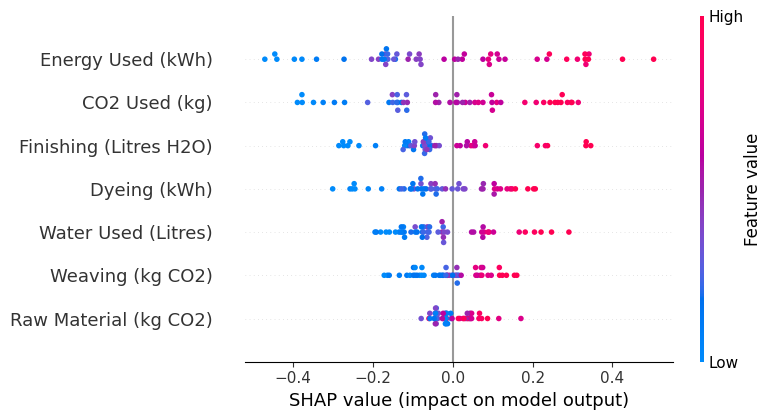

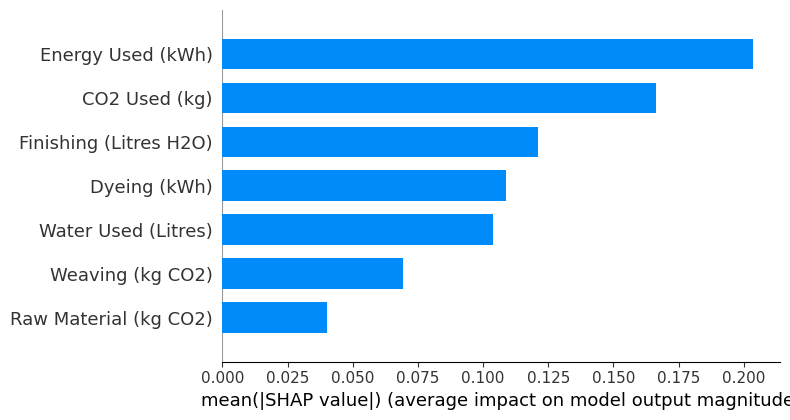

In [ ]:
import shap

# Use KernelExplainer for SVM (since it does not support TreeExplainer)
explainer = shap.KernelExplainer(best_model.predict, X_train[:50])  # Use a small subset for efficiency

# Compute SHAP values
shap_values = explainer.shap_values(X_test[:50])  # Limiting to 50 samples for efficiency

# Summary plot: Feature importance visualization
shap.summary_plot(shap_values, X_test[:50], feature_names=X.columns)

# Bar plot for mean absolute SHAP values
shap.summary_plot(shap_values, X_test[:50], plot_type="bar", feature_names=X.columns)

# Force plot for a single instance (example: first test sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[0], feature_names=X.columns)


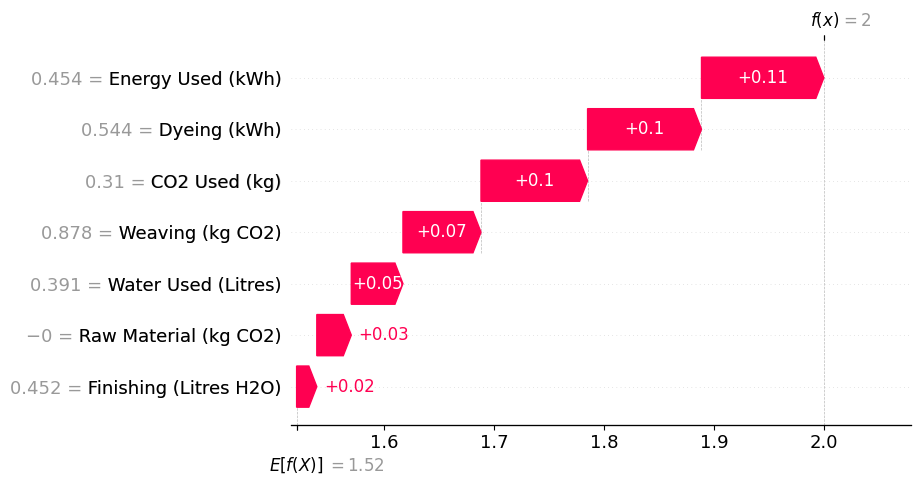

In [31]:
# Select an instance to explain (example: first test sample)
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_test[0], 
                                     feature_names=X.columns))


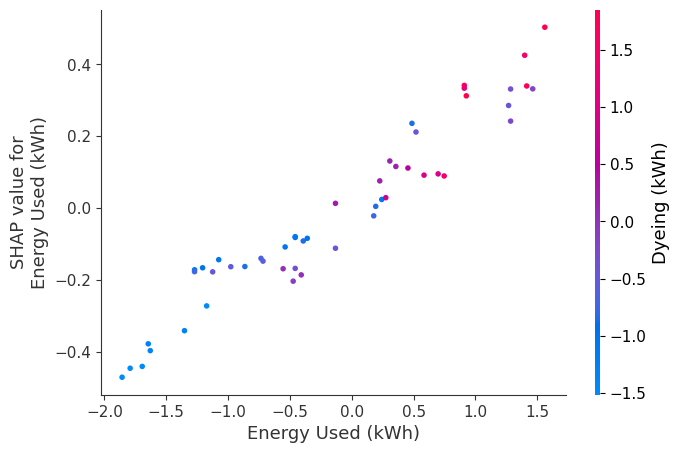

In [37]:
import numpy as np

# Convert shap_values to a NumPy array (if using KernelExplainer)
shap_values_array = np.array(shap_values)

# Limit the number of samples to the size of shap_values_array
num_samples = shap_values_array.shape[0]

# Dependence plot for 'Energy Used (kWh)'
shap.dependence_plot('Energy Used (kWh)', shap_values_array[:num_samples], X_test[:num_samples], feature_names=X.columns)


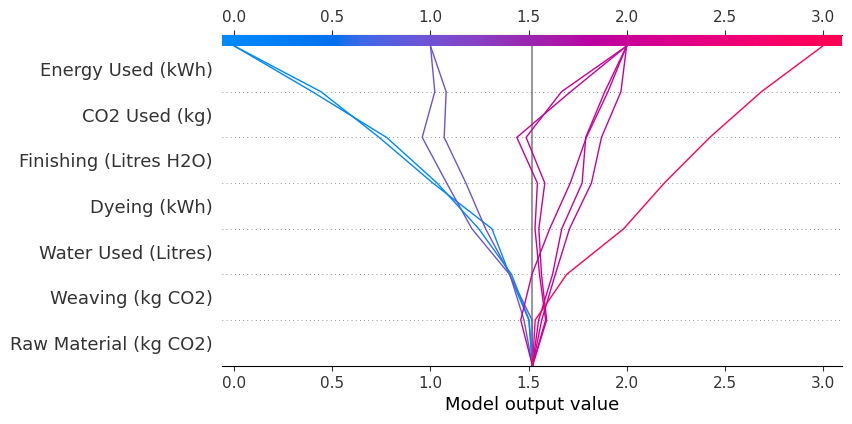

In [39]:
# Ensure feature names are in list format
feature_names_list = list(X.columns)

# Decision plot for multiple test instances
shap.decision_plot(explainer.expected_value, shap_values[:10], X_test[:10], feature_names=feature_names_list)


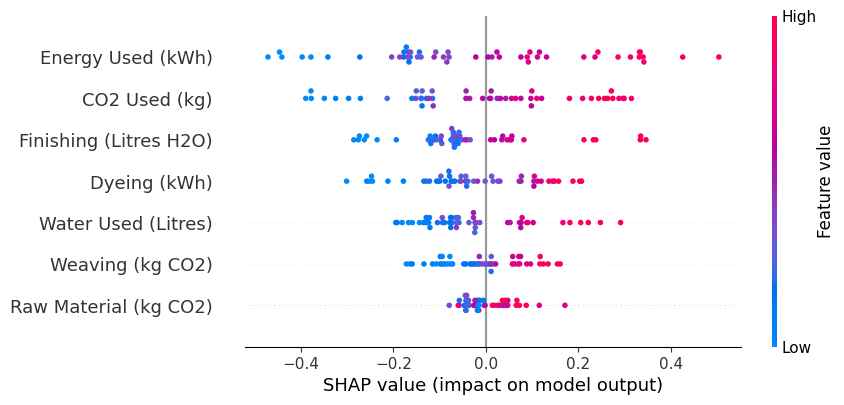

In [41]:
# Ensure the number of rows in X_test matches the number of rows in shap_values
X_test_limited = X_test[:len(shap_values)]

# Convert shap_values to SHAP Explanation object
shap_values_exp = shap.Explanation(values=np.array(shap_values), 
                                   base_values=explainer.expected_value, 
                                   data=X_test_limited, 
                                   feature_names=X.columns)

# Generate Beeswarm plot
shap.plots.beeswarm(shap_values_exp)


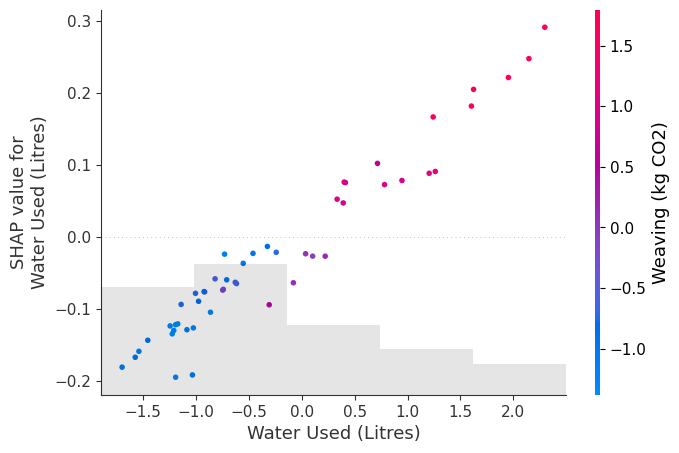

In [43]:
import numpy as np

# Find index of the feature 'Water Used (Litres)'
feature_index = list(X.columns).index("Water Used (Litres)")

# Generate the scatter plot
shap.plots.scatter(shap_values_exp[:, feature_index], color=shap_values_exp)


# Lime Explainable Ai

In [64]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train, 
    feature_names=X.columns, 
    class_names=label_encoder.classes_,  # Ensure class names match label encoding
    mode='classification'
)

# Select an instance to explain (e.g., first test sample)
instance = X_test[1].reshape(1, -1)

# Get the model's predicted class for this instance
predicted_class = best_model.predict(instance)[0]

# Generate explanation for the predicted class
lime_exp = lime_explainer.explain_instance(
    instance[0], 
    best_model.predict_proba, 
    labels=[predicted_class]  # Force LIME to explain the actual prediction
)

# Display explanation
lime_exp.show_in_notebook()


In [48]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train, 
    feature_names=X.columns, 
    class_names=label_encoder.classes_,  # Ensure class names match label encoding
    mode='classification'
)

# Select an instance to explain (e.g., first test sample)
instance = X_test[2].reshape(1, -1)

# Get the model's predicted class for this instance
predicted_class = best_model.predict(instance)[0]

# Generate explanation for the predicted class
lime_exp = lime_explainer.explain_instance(
    instance[0], 
    best_model.predict_proba, 
    labels=[predicted_class]  # Force LIME to explain the actual prediction
)

# Display explanation
lime_exp.show_in_notebook()


In [63]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train, 
    feature_names=X.columns, 
    class_names=label_encoder.classes_,  # Ensure class names match label encoding
    mode='classification'
)

# Select an instance to explain (e.g., first test sample)
instance = X_test[62].reshape(1, -1)

# Get the model's predicted class for this instance
predicted_class = best_model.predict(instance)[0]

# Generate explanation for the predicted class
lime_exp = lime_explainer.explain_instance(
    instance[0], 
    best_model.predict_proba, 
    labels=[predicted_class]  # Force LIME to explain the actual prediction
)

# Display explanation
lime_exp.show_in_notebook()
